In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Obtener los datos históricos de las acciones de Amazon
symbol = 'AMZN'
start_date = '2020-01-01'
end_date = '2023-01-01'
data = yf.download(symbol, start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


In [100]:

# Selecciona solo los precios de cierre ajustados
ts = data['Adj Close'].resample('D').interpolate()


In [101]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # dropna maneja los datos faltantes (NaN)
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Luego puedes usar esta función en tus datos así:
adf_test(data['Adj Close'], 'Stock Price')


ADF Test: Stock Price
ADF Test Statistic       -1.394058
p-value                   0.585121
# Lags Used               0.000000
# Observations          755.000000
Critical Value (1%)      -3.439041
Critical Value (5%)      -2.865376
Critical Value (10%)     -2.568813
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [102]:
# Diferenciación: Calcula la diferencia entre el valor actual y el valor anterior.
data['Adj Close diff'] = data['Adj Close'].diff()

# Eliminar la primera línea porque es NaN
data = data.dropna()

# Mostrar los primeros cinco registros
print(data.head())

# Realizar la prueba ADF de nuevo en los datos diferenciados
result = adfuller(data['Adj Close diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2020-01-03  93.224998  94.309998  93.224998  93.748497  93.748497  75288000   
2020-01-06  93.000000  95.184502  93.000000  95.143997  95.143997  81236000   
2020-01-07  95.224998  95.694504  94.601997  95.343002  95.343002  80898000   
2020-01-08  94.902000  95.550003  94.321999  94.598503  94.598503  70160000   
2020-01-09  95.494499  95.890999  94.790001  95.052498  95.052498  63346000   

            Adj Close diff  
Date                        
2020-01-03       -1.152000  
2020-01-06        1.395500  
2020-01-07        0.199005  
2020-01-08       -0.744499  
2020-01-09        0.453995  
ADF Statistic: -27.917796
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [103]:
from pmdarima.arima import auto_arima

# Define los rangos para p, d, q
p_range = range(0, 8)
d_range = range(0, 3)
q_range = range(0, 8)

# Llama a la función auto_arima
model = auto_arima(train, start_p=min(p_range), start_q=min(q_range), 
                   max_p=max(p_range), max_d=max(d_range), max_q=max(q_range), 
                   seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4702.014, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4431.610, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4700.015, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4330.618, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4277.511, Time=0.14 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4264.827, Time=0.15 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4216.871, Time=0.18 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=4208.029, Time=0.26 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=4187.746, Time=0.37 sec


In [ ]:
# Hacer predicciones en el conjunto de prueba
predictions = model_fit.predict(n_periods=len(test))
# Calcula el error cuadrático medio en las predicciones
mse = mean_squared_error(test, predictions)
print('MSE: %.3f' % mse)

MSE: 2236.011


In [ ]:
predictions

2022-05-26    105.358573
2022-05-27    105.128020
2022-05-28    104.903031
2022-05-29    104.826581
2022-05-30    104.027115
                 ...    
2022-12-26     33.201747
2022-12-27     32.863687
2022-12-28     32.525627
2022-12-29     32.187568
2022-12-30     31.849508
Freq: D, Length: 219, dtype: float64

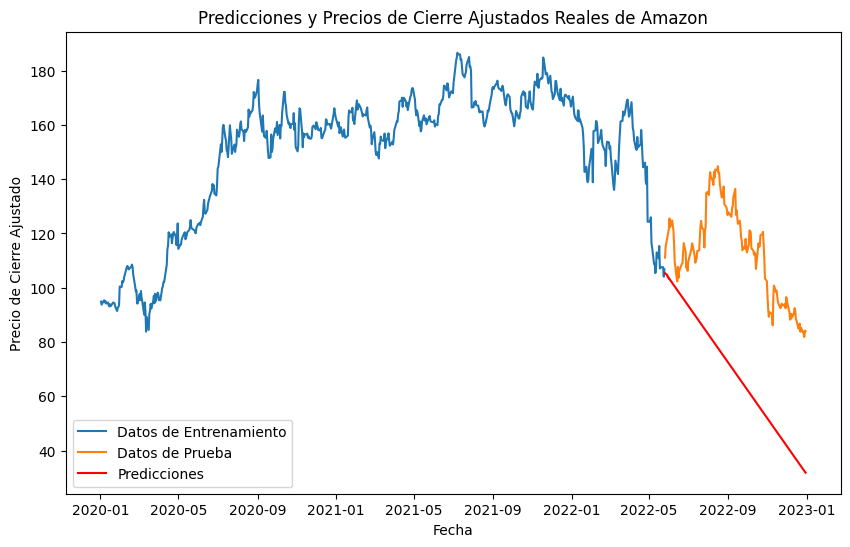

In [ ]:
# Visualiza las predicciones y los datos reales
plt.figure(figsize=(10,6))
plt.plot(train, label='Datos de Entrenamiento')
plt.plot(test.index, test.values, label='Datos de Prueba')
plt.plot(test.index, predictions, label='Predicciones', color='red')
plt.title('Predicciones y Precios de Cierre Ajustados Reales de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

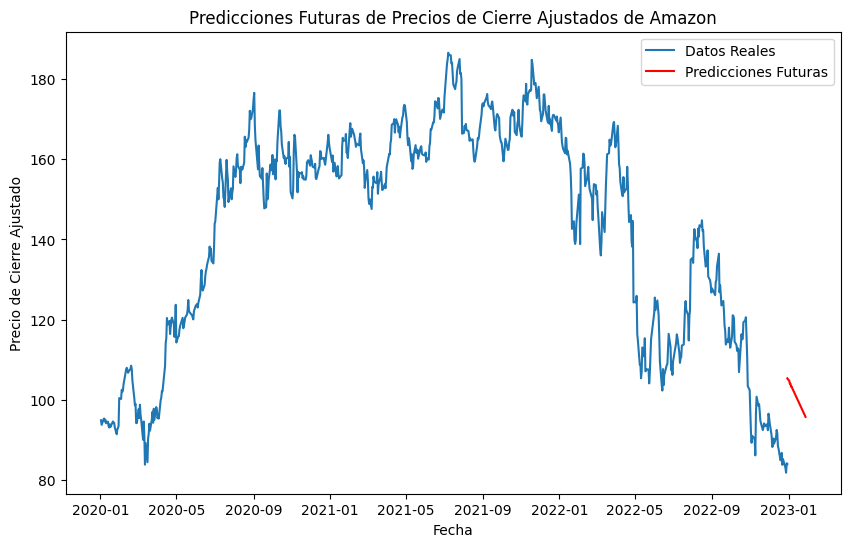

In [ ]:
# Realiza predicciones para el futuro
future_periods = 30
future_predictions = model_fit.predict(n_periods=future_periods)


# Visualiza las predicciones para el futuro
plt.figure(figsize=(10,6))
plt.plot(ts, label='Datos Reales')
plt.plot(pd.date_range(start=ts.index[-1], periods=future_periods, freq='D'), future_predictions, label='Predicciones Futuras', color='red')
plt.title('Predicciones Futuras de Precios de Cierre Ajustados de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)


MSE: 2236.011
RMSE: 47.286
MAE: 44.021
MAPE: 39.646
